 # Zomato Bangalore Restaurant 🇮🇳

In this notebook we are going to:
    
    1) Clean our datasets & explore the variables 
    2) Identify the best restaurants
    3) Explore the services, cuisine, price of the best restaurants
    4) Analyze the best location for a new restaurant

### **Attribute Information from our Zomato dataset:**

    - url: contains the url of the restaurant in the zomato website
    - address: contains the address of the restaurant in Bengaluru
    - name: contains the name of the restaurant
    - online_order: whether online ordering is available in the restaurant or not
    - book_table: table book option available or not
    - rate: contains the overall rating of the restaurant out of 5
    - votes: contains total number of rating for the restaurant 
    - phone: contains the phone number of the restaurant
    - location: contains the neighborhood in which the restaurant is located
    - rest_type: restaurant type
    - dish_liked: dishes people liked in the restaurant
    - cuisines: food styles, separated by comma
    - approx_cost(for two people): contains the approximate cost for meal for two people
    - reviews_list: list of tuples containing reviews for the restaurant, each tuple
    - menu_item: contains list of menus available in the restaurant
    - listed_in(type): type of meal
    - listed_in(city): contains the neighborhood in which the restaurant is listed

In [1]:
# First step: import the libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import missingno as msno
import os
import sys
from scipy.stats import iqr
from scipy.stats import skew
from scipy.stats import norm, kurtosis, stats
import ast

# Importing plotly
from plotly.offline import init_notebook_mode, iplot, plot
from chart_studio.plotly import iplot
import plotly.figure_factory as ff
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

# Text processing libraries
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist

# Sklearn 
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Importing my own cool functions
from Functions_NLP import *

import warnings
warnings.filterwarnings('ignore')

## Statistical overview & data cleaning - Zomato dataset

In [2]:
# Loading and inspecting the datasets
data = pd.read_csv('zomato.csv')

print('Zomato:')
print('Shape:', data.shape)
print('Columns:', data.columns)

data.head(3)

Zomato:
Shape: (51717, 17)
Columns: Index(['url', 'address', 'name', 'online_order', 'book_table', 'rate', 'votes',
       'phone', 'location', 'rest_type', 'dish_liked', 'cuisines',
       'approx_cost(for two people)', 'reviews_list', 'menu_item',
       'listed_in(type)', 'listed_in(city)'],
      dtype='object')


,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari


In [3]:
# Let's make a copy of the data so we keep the original intact
zomato = data.copy()

In [4]:
# Checking Zomato's datatypes
zomato.dtypes

url                            object
address                        object
name                           object
online_order                   object
book_table                     object
rate                           object
votes                           int64
phone                          object
location                       object
rest_type                      object
dish_liked                     object
cuisines                       object
approx_cost(for two people)    object
reviews_list                   object
menu_item                      object
listed_in(type)                object
listed_in(city)                object
dtype: object

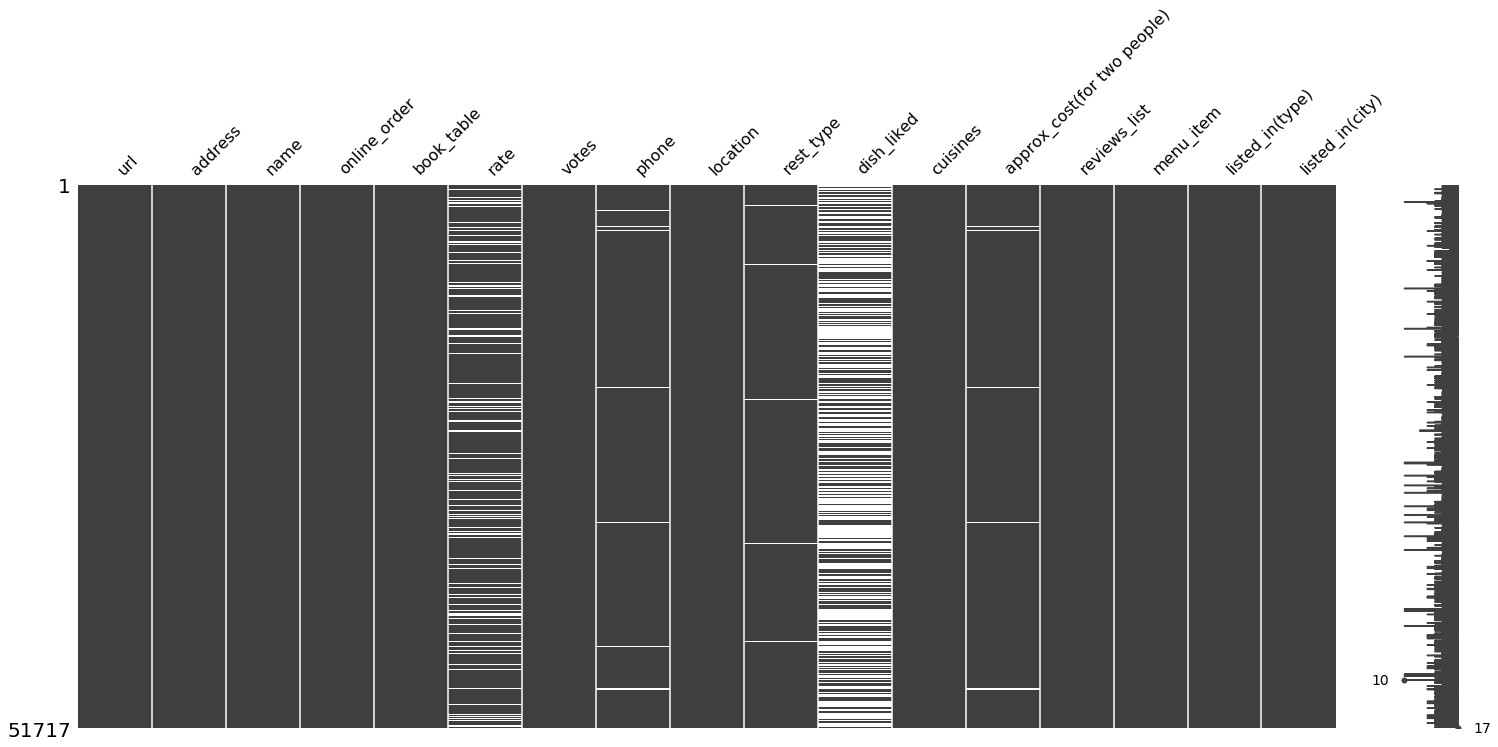

In [5]:
# Is there missing data?
msno.matrix(zomato)

Index(['dish_liked', 'rate', 'phone', 'approx_cost(for two people)',
       'rest_type', 'cuisines', 'location'],
      dtype='object')


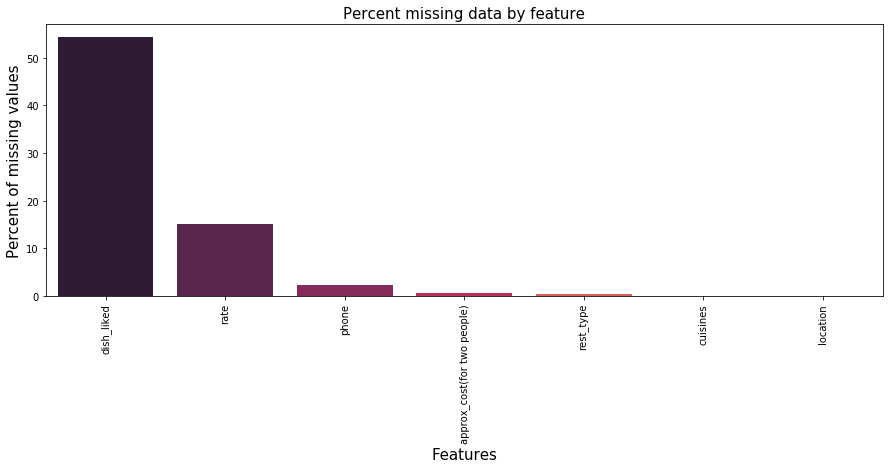

In [6]:
# Checking the percentage for missing data
total = zomato.isnull().sum().sort_values(ascending=False)
percent = (zomato.isnull().sum()/zomato.isnull().count()*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).head(7)

f, ax = plt.subplots(figsize=(15, 5))
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index, y=missing_data['Percent'], palette="rocket")
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

print(missing_data.index)

In [7]:
# Checking for duplicates
zomato.duplicated().sum()

0

In [8]:
# Simplifying variables - renaming
zomato.rename(columns={'approx_cost(for two people)': 'average_cost', 'listed_in(city)': 'neighborhood', 'listed_in(type)': 'type'}, inplace=True)

In [9]:
# Clean dish_liked column
zomato['dish_liked'] = zomato['dish_liked'].fillna('none')

In [10]:
# Clean rate column and turn it into type float
zomato['rate'].replace(('NEW','-'),np.nan,inplace =True) 
zomato['rate'] = zomato['rate'].astype('str').apply(lambda x: x.replace('/5','').strip()).astype('float')

# Checking our percentage of null values after 1st cleaning step
print(zomato['rate'].isnull().sum() / zomato['rate'].isnull().count())

0.19436548910416304


In [11]:
# Replace missing rates with rates from reviews_list column
zomato['reviews_list'] = zomato['reviews_list'].apply(lambda x: ast.literal_eval(x))

def get_rate(x):
    
    #extract the rate value out of a string inside tuple
    # ensure that x is not Null and there is more than one rate
    
    if not x or len(x) <= 1:
        return None
    rate = [float(i[0].replace('Rated','').strip())  for i in x if type(i[0])== str]
    return round((sum(rate)/len(rate)),1)

zomato['review_rate']  = zomato['reviews_list'].apply(lambda x : get_rate(x))

nan_index = zomato.query('rate != rate & review_rate == review_rate').index
for i in nan_index:
    zomato.loc[i,'rate'] = zomato.loc[i,'review_rate'] 

# Checking our percentage of null values after 2nd cleaning step
print(zomato['rate'].isnull().sum() / zomato['rate'].isnull().count())

0.16516812653479512


In [12]:
# Filling the remaining null values in rate with the mean
zomato['rate'].fillna((zomato['rate'].mean()), inplace=True)

In [13]:
# Rounding the 'rate' to 1 decimal
zomato['rate'] = round(zomato['rate'], 1)

In [14]:
# Cleaning average_cost column, turn it into type float and fill missing values with mean
zomato['average_cost'] = zomato['average_cost'].fillna(0)
zomato['average_cost'] = zomato['average_cost'].astype(str).apply(lambda x: int(x.replace(',',''))).astype(float)
zomato['average_cost'] = zomato['average_cost'].replace(0, zomato['average_cost'].mean())

In [15]:
# Cleaning 'rest_type' & 'cuisines' column
zomato['rest_type'] = zomato['rest_type'].fillna('None')
zomato['cuisines'] = zomato['cuisines'].fillna('None')

In [16]:
# Encoding variables online_order, book_table

# online_order
print('Online_order before...')
print(zomato['online_order'].value_counts().sort_index())
zomato['online_order_encoded'] = LabelEncoder().fit_transform(zomato['online_order'])
print('...after')
print(zomato['online_order_encoded'].value_counts().sort_index())

print('')
# book_table
print('Book_table before...')
print(zomato['book_table'].value_counts().sort_index())
zomato['book_table_encoded'] = LabelEncoder().fit_transform(zomato['book_table'])
print('...after')
print(zomato['book_table_encoded'].value_counts().sort_index())

print('')
print ('\033[1m' + 'Encoding successfuly completed!')

Online_order before...
No     21273
Yes    30444
Name: online_order, dtype: int64
...after
0    21273
1    30444
Name: online_order_encoded, dtype: int64

Book_table before...
No     45268
Yes     6449
Name: book_table, dtype: int64
...after
0    45268
1     6449
Name: book_table_encoded, dtype: int64

Encoding successfuly completed!


In [17]:
# Dropping unnecessary columns and check clean dataframe
zomato = zomato.drop(columns=['reviews_list', 'review_rate', 'menu_item', 'location','url', 'address', 'phone'])

print(zomato.shape)
zomato.head(3)

(51717, 13)


,name,online_order,book_table,rate,votes,rest_type,dish_liked,cuisines,average_cost,type,neighborhood,online_order_encoded,book_table_encoded
0,Jalsa,Yes,Yes,4.1,775,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800.0,Buffet,Banashankari,1,1
1,Spice Elephant,Yes,No,4.1,787,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800.0,Buffet,Banashankari,1,0
2,San Churro Cafe,Yes,No,3.8,918,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800.0,Buffet,Banashankari,1,0


In [18]:
# Checking the final shape of our dataset
zomato.shape

(51717, 13)

In [19]:
# Counting the number of missing values in our dataframe
zomato.isnull().sum().any()

False

## Preprocessing categorical data - Zomato dataset

**Text variables to clean & analyze**
    - dish_liked
    - cuisines
    - rest_type

In [20]:
#Cleaning dish_liked
zomato['dish_liked2'] = zomato['dish_liked'].apply(lambda x: clean_text(x))

In [21]:
#We substitute the word 'none' for an empty space
zomato['dish_liked2'] = zomato['dish_liked2'].apply(lambda x: x.replace('none', ''))

In [22]:
#Cleaning cuisines
zomato['cuisines2'] = zomato['cuisines'].apply(lambda x: clean_text(x))

In [23]:
#Cleaning rest_type
zomato['rest_type2'] = zomato['rest_type'].apply(lambda x: clean_text(x))

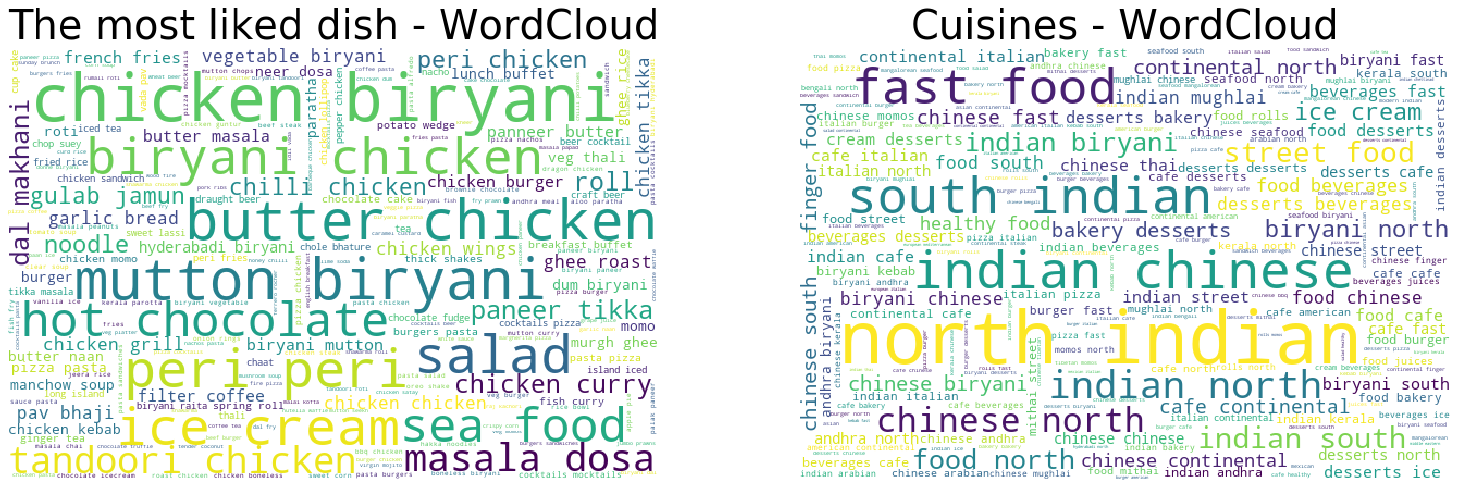

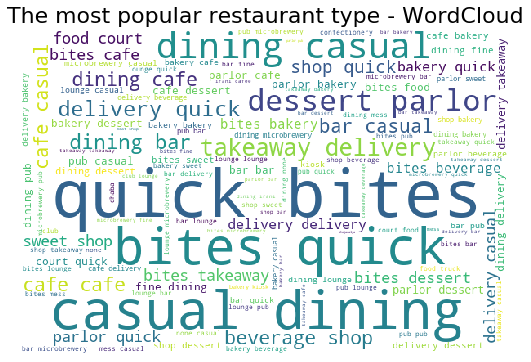

In [24]:
from wordcloud import WordCloud

dish_liked = zomato['dish_liked2']
cuisines = zomato['cuisines2']
rest_type = zomato['rest_type2']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(dish_liked))

ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('The most liked dish - WordCloud',fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(cuisines))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Cuisines - WordCloud',fontsize=40);

fig, (ax1) = plt.subplots(1, figsize=[22, 6])
wordcloud3 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(rest_type))

ax1.imshow(wordcloud3)
ax1.axis('off')
ax1.set_title('The most popular restaurant type - WordCloud',fontsize=22);

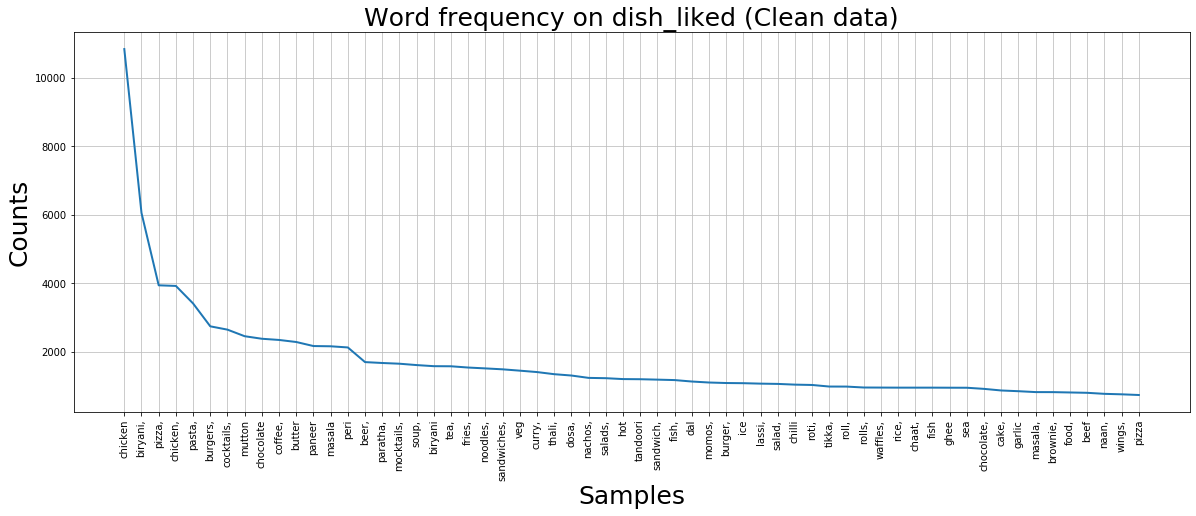

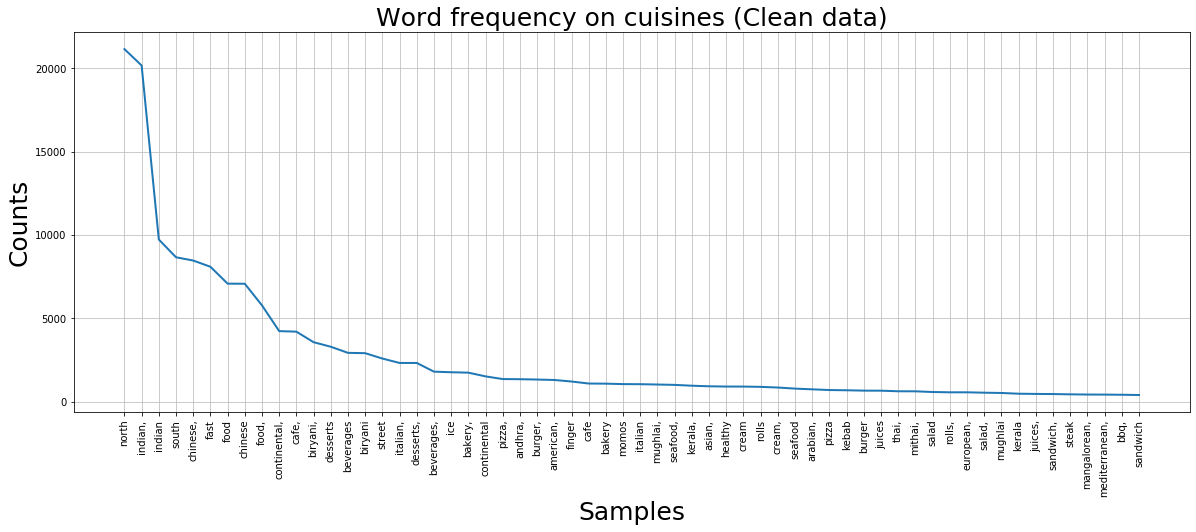

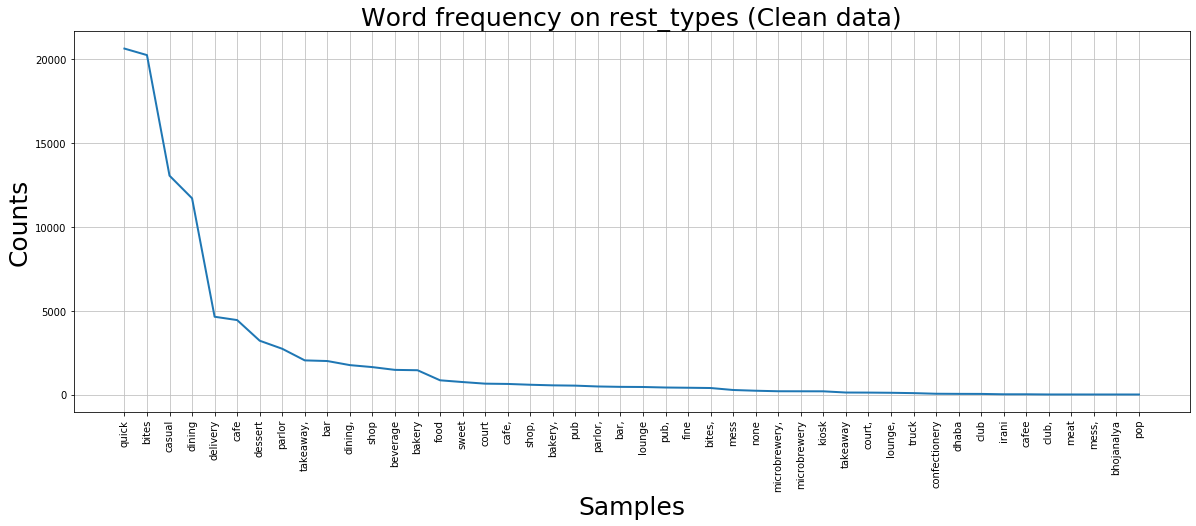

In [25]:
# Clean data

freq_dist = FreqDist([word for text in zomato['dish_liked2'].str.replace('[^a-za-z0-9^,!.\/+-=]',' ') for word in text.split()])
plt.figure(figsize=(20, 7))
plt.title('Word frequency on dish_liked (Clean data)').set_fontsize(25)
plt.xlabel('').set_fontsize(25)
plt.ylabel('').set_fontsize(25)
freq_dist.plot(60,cumulative=False)
plt.show()

freq_dist = FreqDist([word for text in zomato['cuisines2'].str.replace('[^a-za-z0-9^,!.\/+-=]',' ') for word in text.split()])
plt.figure(figsize=(20, 7))
plt.title('Word frequency on cuisines (Clean data)').set_fontsize(25)
plt.xlabel('').set_fontsize(25)
plt.ylabel('').set_fontsize(25)
freq_dist.plot(60,cumulative=False)
plt.show()

freq_dist = FreqDist([word for text in zomato['rest_type2'].str.replace('[^a-za-z0-9^,!.\/+-=]',' ') for word in text.split()])
plt.figure(figsize=(20, 7))
plt.title('Word frequency on rest_types (Clean data)').set_fontsize(25)
plt.xlabel('').set_fontsize(25)
plt.ylabel('').set_fontsize(25)
freq_dist.plot(60,cumulative=False)
plt.show()

In [26]:
#Deleting the old dish_liked
del zomato['dish_liked']

In [27]:
#Renaming the new cleaned dish_liked
zomato.rename(columns={'dish_liked2': 'dish_liked'}, inplace=True)

In [28]:
#Deleting the old cuisines
del zomato['cuisines']

In [29]:
#Renaming the new cleaned cuisines
zomato.rename(columns={'cuisines2': 'cuisines'}, inplace=True)

In [30]:
#Deleting the old rest_type
del zomato['rest_type']

In [31]:
#Renaming the new cleaned rest_type
zomato.rename(columns={'rest_type2': 'rest_type'}, inplace=True)

<span style='color:Blue'> **We have successfully cleaned our categorical data!**  </span>

## Statistical overview & data cleaning - Location dataset

In [32]:
# Loading and inspecting the dataset
loc = pd.read_csv('locations.csv')

print('Locations:')
print('Shape:', loc.shape)
print('Columns:', loc.columns)

data.head(3)

Locations:
Shape: (94, 2)
Columns: Index(['Name', 'geo_loc'], dtype='object')


,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari


In [33]:
# Is there missing data?
show_null(loc)

,Amount,Missing data (%),type
geo_loc,6,6.382979,object


In [34]:
# Writing all columns in lower case
loc.columns = loc.columns.str.lower()

In [35]:
# Isolating location name in locations dataframe
loc['location'] = loc['name'].str.split(n=1).str[1]
loc.head(3)

,name,geo_loc,location
0,Bangalore Banashankari,"(12.9152208, 77.573598)",Banashankari
1,Bangalore Basavanagudi,"(12.9417261, 77.5755021)",Basavanagudi
2,Bangalore Mysore Road,"(12.9314092, 77.5067138)",Mysore Road


In [36]:
# Renaming column for the left join & dropping the name column
loc.rename(columns={'location': 'neighborhood'}, inplace=True)
loc = loc.drop(columns=['name'])

In [37]:
# Merge geo locations from locations dataframe with zomato dataframe
zomato_clean = pd.merge(zomato, loc, how='left')
zomato_clean.head(3)

,name,online_order,book_table,rate,votes,average_cost,type,neighborhood,online_order_encoded,book_table_encoded,dish_liked,cuisines,rest_type,geo_loc
0,Jalsa,Yes,Yes,4.1,775,800.0,Buffet,Banashankari,1,1,"pasta, lunch buffet, masala papad, paneer laja...","north indian, mughlai, chinese",casual dining,"(12.9152208, 77.573598)"
1,Spice Elephant,Yes,No,4.1,787,800.0,Buffet,Banashankari,1,0,"momos, lunch buffet, chocolate nirvana, thai g...","chinese, north indian, thai",casual dining,"(12.9152208, 77.573598)"
2,San Churro Cafe,Yes,No,3.8,918,800.0,Buffet,Banashankari,1,0,"churros, cannelloni, minestrone soup, hot choc...","cafe, mexican, italian","cafe, casual dining","(12.9152208, 77.573598)"


In [38]:
# Checking in which neighborhood there is missing geo_loc
features = ['geo_loc', 'neighborhood']
dataframe = zomato_clean[features]

dataframe = dataframe[dataframe.isna().any(axis=1)]
dataframe.head(3)

,geo_loc,neighborhood
6742,NaN,Brookefield
6743,NaN,Brookefield
6744,NaN,Brookefield


In [39]:
# We extract the coordinates from Brookefield from Internet and fill the null values
zomato_clean['geo_loc'] = zomato_clean['geo_loc'].fillna('(12.9657, 77.7188)')

In [40]:
# Final check of missing values in our dataframe
zomato_clean.isnull().sum().any()

False

In [41]:
# Final check that the variables have the right category
zomato_clean.dtypes

name                     object
online_order             object
book_table               object
rate                    float64
votes                     int64
average_cost            float64
type                     object
neighborhood             object
online_order_encoded      int64
book_table_encoded        int64
dish_liked               object
cuisines                 object
rest_type                object
geo_loc                  object
dtype: object

<span style='color:Blue'> **We have successfully cleaned and merged the Zomato and Location data!**  </span>

## Data Visualization

In [42]:
#Split data according to column data type
num_data = zomato_clean.select_dtypes(exclude=['object', 'datetime'])
cat_data = zomato_clean.select_dtypes(include=['object'])

print('The numerical data is:')
print(num_data.shape)
print(num_data.columns)
print('')
print('The categorical data is:')
print(cat_data.shape)
print(cat_data.columns)

The numerical data is:
(51717, 5)
Index(['rate', 'votes', 'average_cost', 'online_order_encoded',
       'book_table_encoded'],
      dtype='object')

The categorical data is:
(51717, 9)
Index(['name', 'online_order', 'book_table', 'type', 'neighborhood',
       'dish_liked', 'cuisines', 'rest_type', 'geo_loc'],
      dtype='object')


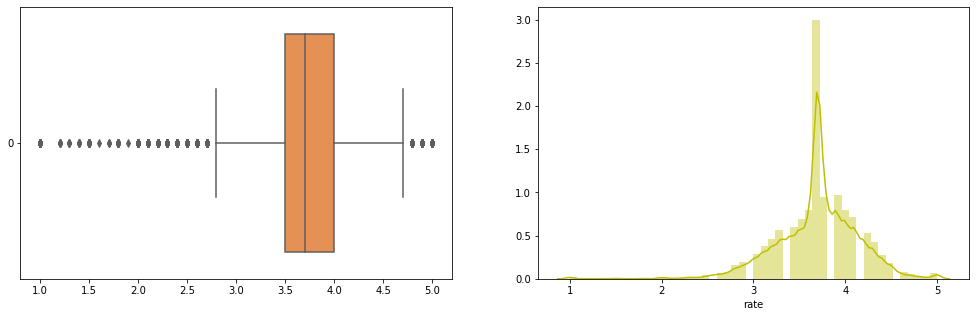

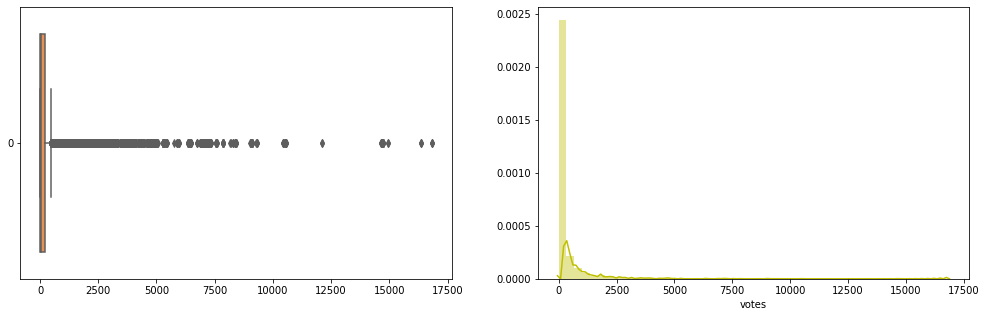

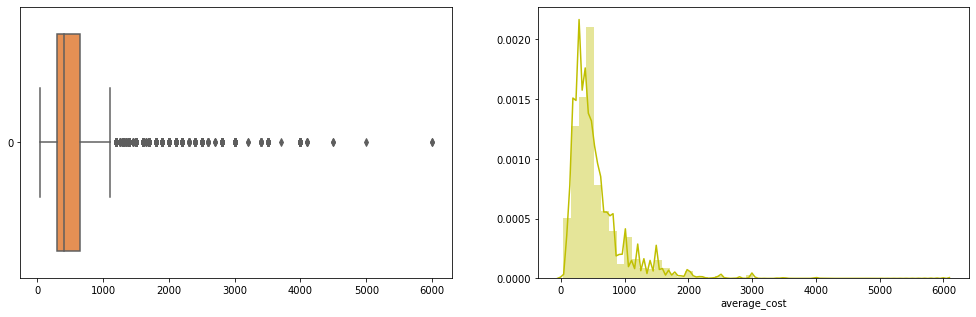

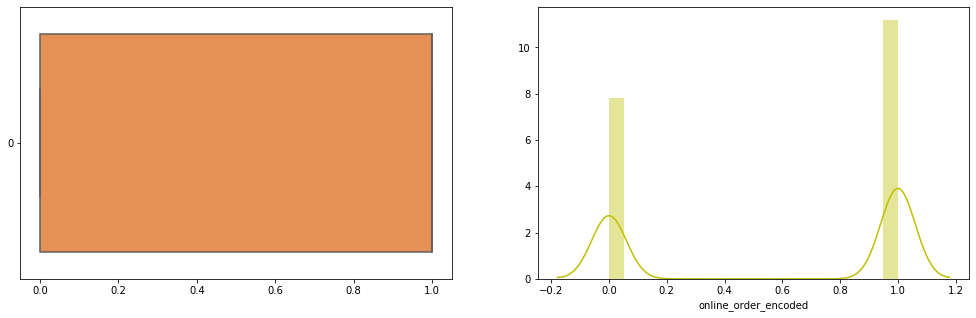

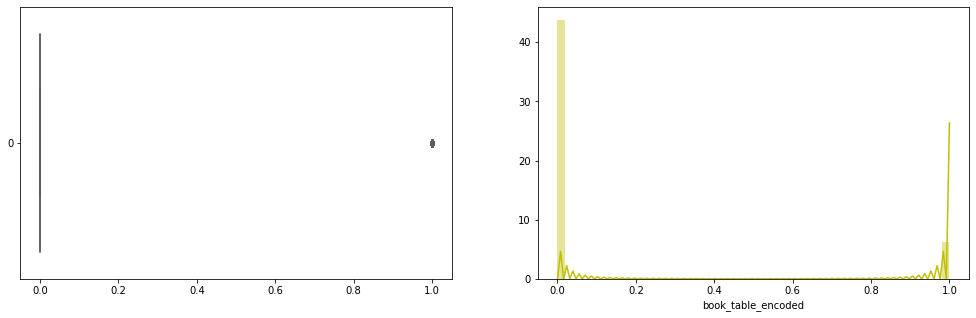

In [43]:
#Quick overview cleaned numerical variables - distribution plot
for i, col in enumerate(num_data.columns):
    plt.figure(figsize=(17,5))
    plt.subplot(121)
    sns.boxplot(data=zomato_clean[col], palette='YlOrRd', orient ='h')
    plt.subplot(122)
    sns.distplot(zomato_clean[col], color='y')

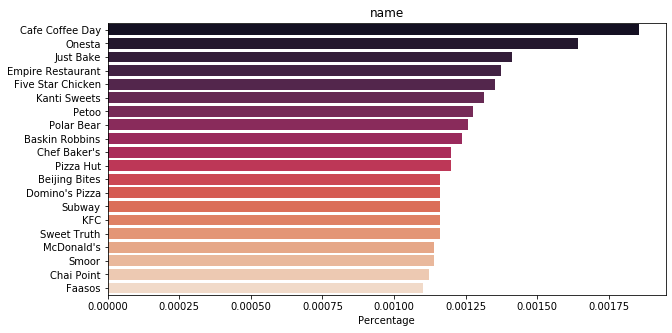

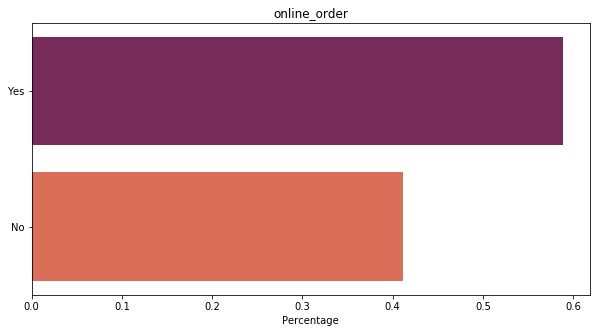

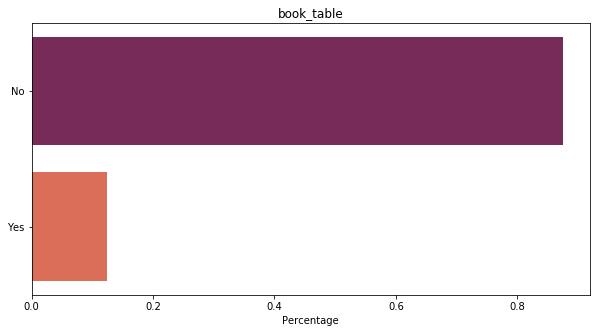

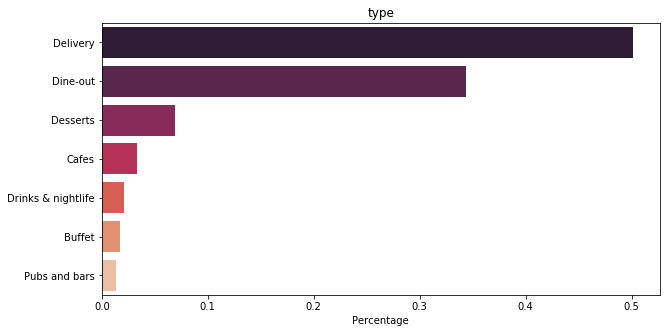

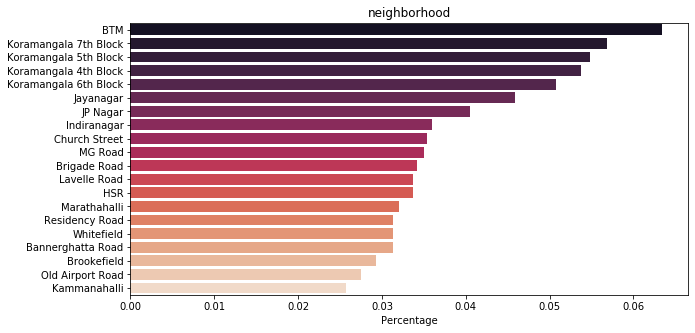

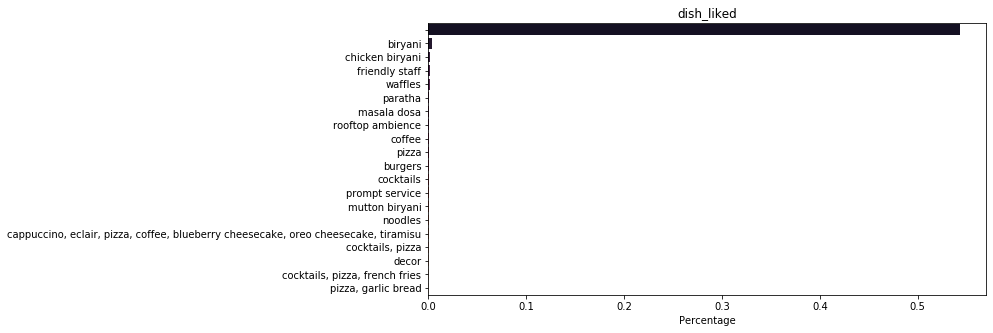

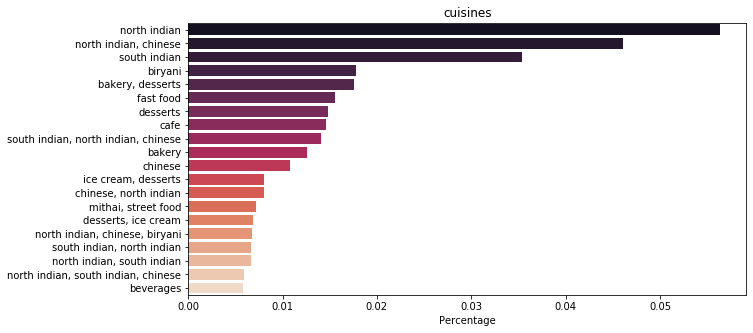

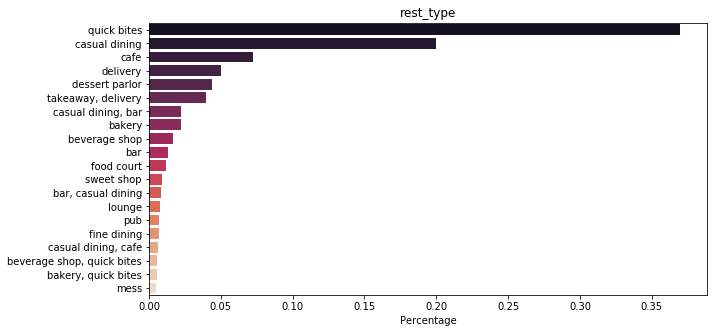

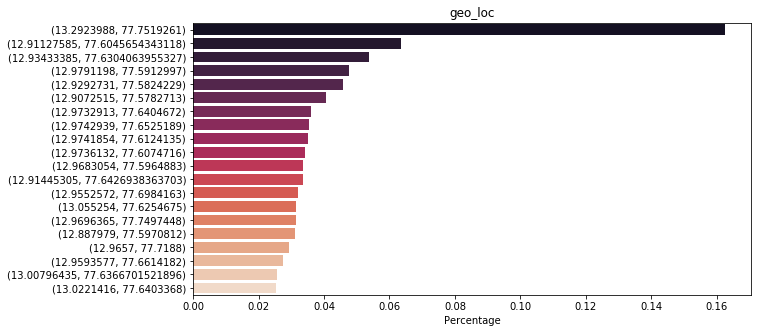

In [44]:
#Quick overview cleaned categorical variables - distribution plot
for i, col in enumerate(cat_data.columns):
    fig, ax = plt.subplots(figsize = (10, 5))
    top = pd.DataFrame(columns = cat_data.columns)
    top[col] = zomato_clean[col].value_counts(normalize=True)[:20]
    sns.barplot(top[col], top[col].index, palette='rocket')
    plt.xlabel('Percentage')
    plt.title(col)

### Let's take a deeper look at our variables

In [45]:
import plotly.graph_objects as go

colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen']
labels = zomato_clean.groupby('online_order')['online_order'].unique()
values = zomato_clean.groupby('online_order')['online_order'].value_counts()

fig = go.Figure(data=[go.Pie(labels=labels,
                             values=values, 
                            title='% Restaurants with Online Order', pull=[0.1, 0])])
fig.update_traces(hoverinfo='label+percent+value', textinfo='percent+label', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.show()

In [46]:
import plotly.graph_objects as go

colors = ['darkorange', 'lightgreen']
labels = zomato_clean.groupby('book_table')['book_table'].unique()
values = zomato_clean.groupby('book_table')['book_table'].value_counts()

fig = go.Figure(data=[go.Pie(labels=labels,
                             values=values, 
                            title='% Restaurants offering Book table', pull=[0.2, 0])])
fig.update_traces(hoverinfo='label+percent+value', textinfo='percent+label', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.show()

Text(0.5, 1.0, 'Rating of the restaurants in Bangalore')

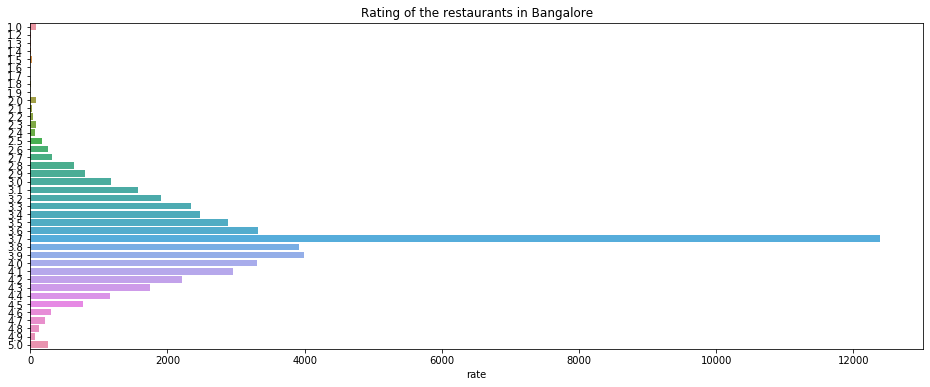

In [47]:
# Plotting the rate of the restaurants
plt.figure(figsize=(16, 6))

sns.barplot(y=zomato_clean['rate'].value_counts().index,x=zomato_clean['rate'].value_counts(),
            orient='h').set_title('Rating of the restaurants in Bangalore')

Text(0.5, 1.0, 'Top 5 cuisines in Bangalore')

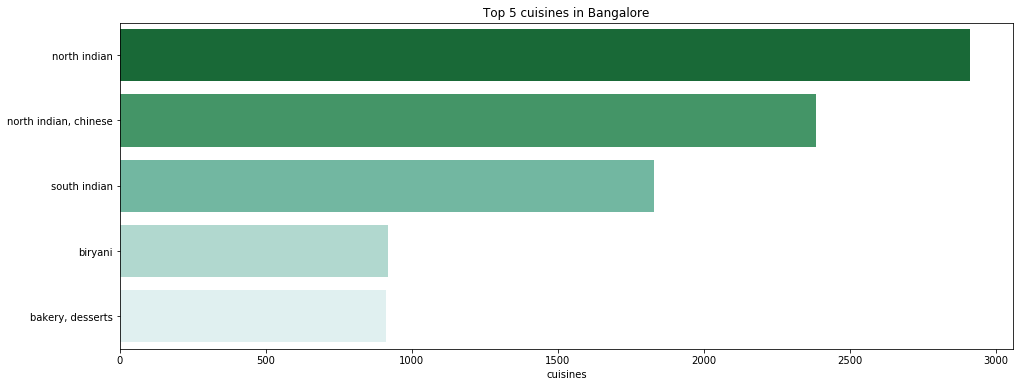

In [48]:
# Plotting the rate of the restaurants
plt.figure(figsize=(16, 6))

sns.barplot(y=zomato_clean['cuisines'].value_counts()[:5].index,x=zomato_clean['cuisines'].value_counts()[:5],
            orient='h', palette="BuGn_r").set_title('Top 5 cuisines in Bangalore')

Text(0.5, 1.0, 'Average cost distribution')

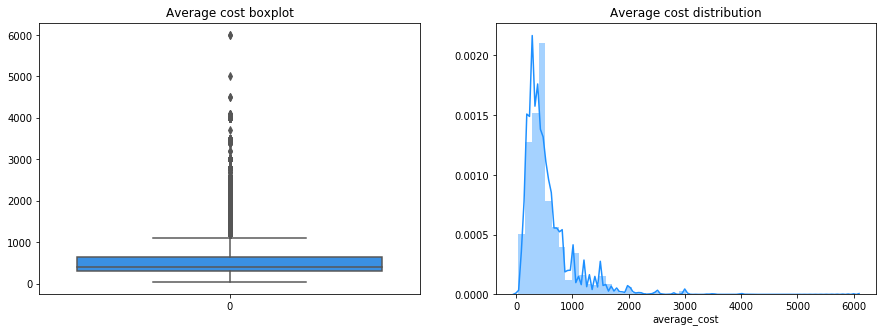

In [49]:
# Plotting the average cost per restaurant (for 2 pax)
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.boxplot(data=zomato_clean.average_cost, color='dodgerblue')
plt.title('Average cost boxplot')
plt.subplot(122)
sns.distplot(zomato_clean.average_cost, color='dodgerblue')
plt.title('Average cost distribution')

Text(0.5, 1.0, 'Location restaurants in Bangalore')

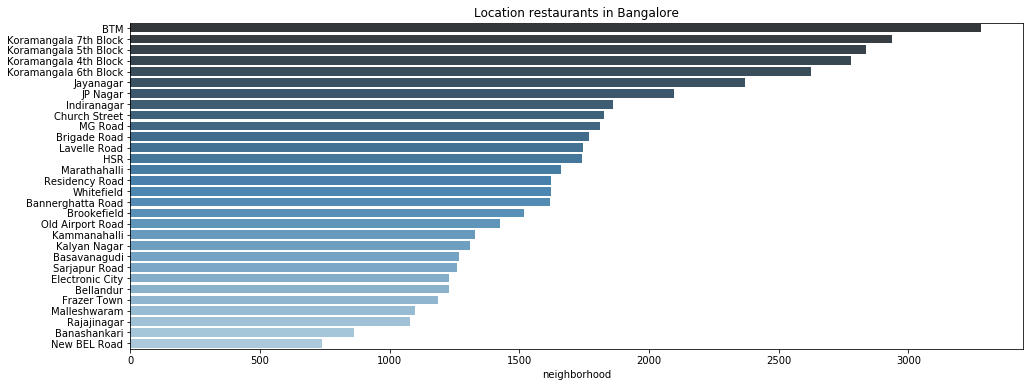

In [50]:
# Plotting the neighborhoods where the restaurants are located
plt.figure(figsize=(16, 6))

sns.barplot(y=zomato_clean['neighborhood'].value_counts().index,x=zomato_clean['neighborhood'].value_counts(),
            orient='h', palette="Blues_d").set_title('Location restaurants in Bangalore')

### Correlation

In [51]:
zomato_clean.columns

Index(['name', 'online_order', 'book_table', 'rate', 'votes', 'average_cost',
       'type', 'neighborhood', 'online_order_encoded', 'book_table_encoded',
       'dish_liked', 'cuisines', 'rest_type', 'geo_loc'],
      dtype='object')

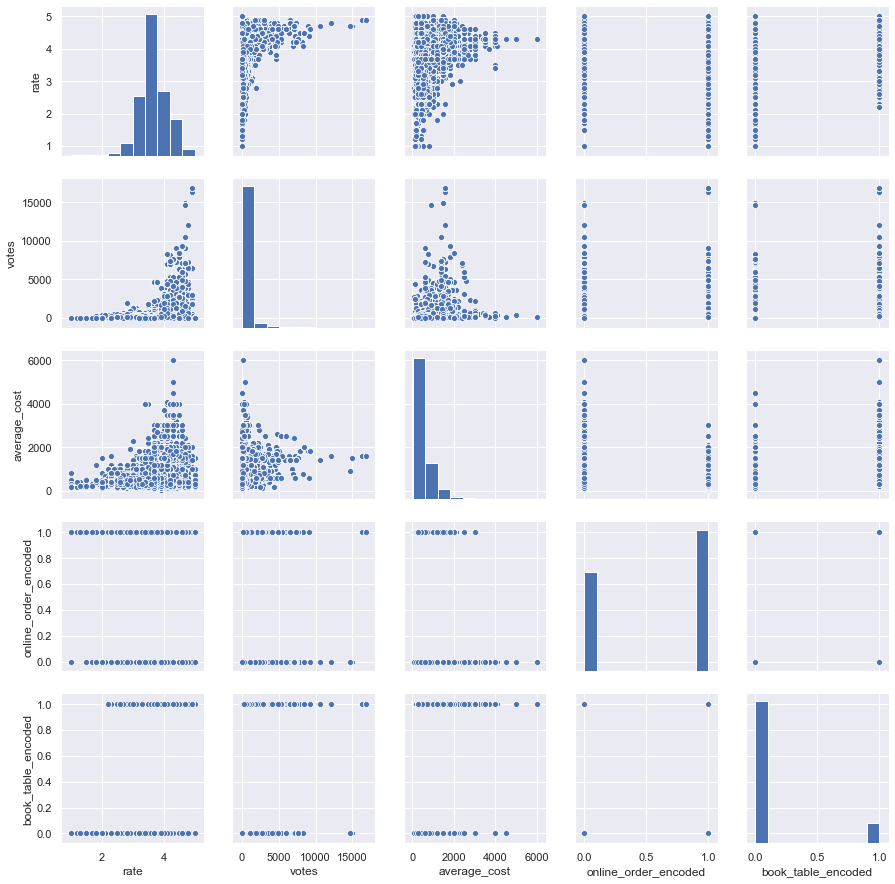

In [52]:
#scatterplot
sns.set()
most_relevant = ['rate', 'votes', 'average_cost','online_order_encoded', 'book_table_encoded']
sns.pairplot(zomato_clean[most_relevant], height = 2.5)
plt.show();

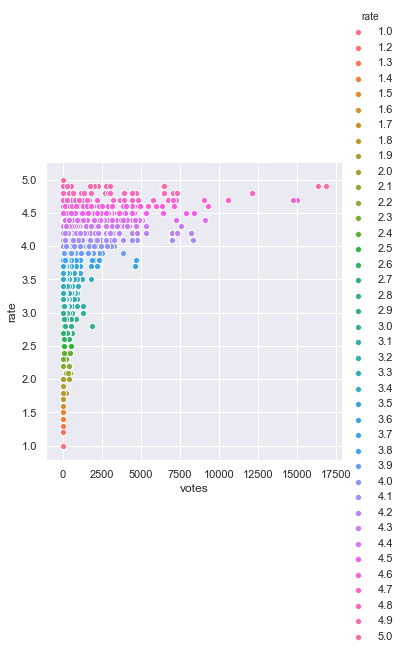

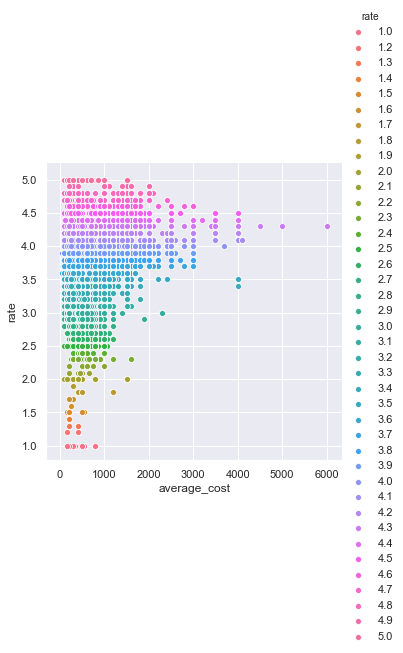

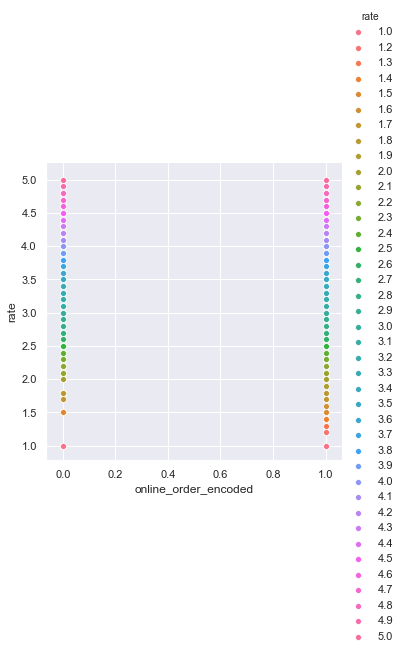

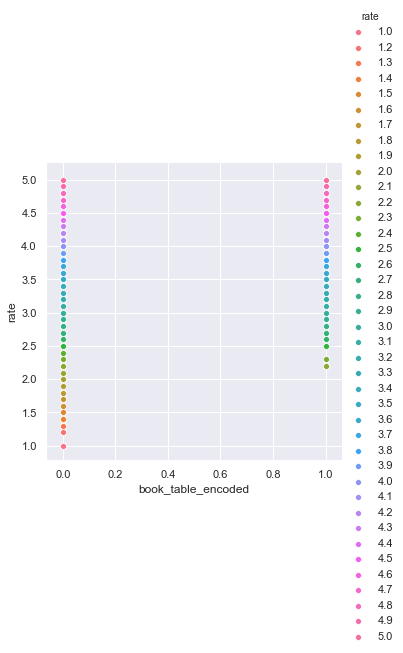

In [53]:
sns.pairplot(x_vars=['votes'], y_vars=['rate'], data=zomato_clean[most_relevant], hue='rate', height=5, aspect=1)
sns.pairplot(x_vars=['average_cost'], y_vars=['rate'], data=zomato_clean[most_relevant], hue='rate', height=5, aspect=1)
sns.pairplot(x_vars=['online_order_encoded'], y_vars=['rate'], data=zomato_clean[most_relevant], hue='rate', height=5, aspect=1)
sns.pairplot(x_vars=['book_table_encoded'], y_vars=['rate'], data=zomato_clean[most_relevant], hue='rate', height=5, aspect=1)

In [54]:
# Correlation heatmap of variables 

numerical = ['rate', 'votes', 'average_cost','online_order_encoded', 'book_table_encoded']
df_numerical = zomato_clean[numerical]

corr = df_numerical.corr()

m = corr.values
k = np.round(m,2)
x=['rate', 'votes', 'average_cost','online_order_encoded', 'book_table_encoded']
y=['rate', 'votes', 'average_cost','online_order_encoded', 'book_table_encoded']

fig = ff.create_annotated_heatmap(k, x=x, y=y, colorscale='Viridis')

fig.update_layout(
    title='Correlation Heatmap',
    xaxis_nticks=105,
    yaxis_nticks=105,
    autosize=False,
    width=610,
    height=610)

fig.show()

### Top restaurants

In [55]:
# Let's make a copy of the data so we keep the clean dataset intact
df2 = zomato_clean.copy()

In [56]:
df2.columns

Index(['name', 'online_order', 'book_table', 'rate', 'votes', 'average_cost',
       'type', 'neighborhood', 'online_order_encoded', 'book_table_encoded',
       'dish_liked', 'cuisines', 'rest_type', 'geo_loc'],
      dtype='object')

In [57]:
df2.describe()

,rate,votes,average_cost,online_order_encoded,book_table_encoded
count,51717.000000,51717.000000,51717.000000,51717.000000,51717.000000
mean,3.697270,283.697527,555.406706,0.588665,0.124698
std,0.444749,803.838853,437.380329,0.492080,0.330379
min,1.000000,0.000000,40.000000,0.000000,0.000000
25%,3.500000,7.000000,300.000000,0.000000,0.000000
50%,3.700000,41.000000,400.000000,1.000000,0.000000
75%,4.000000,198.000000,650.000000,1.000000,0.000000
max,5.000000,16832.000000,6000.000000,1.000000,1.000000


In [58]:
#We found some duplicates - because some of the rest are chains
df2= df2.drop_duplicates(subset='name',keep='first')

In [59]:
#Find the cheapest restaurant
df_lowcost=df2[['name','average_cost','neighborhood','rest_type','cuisines','online_order','book_table','dish_liked']].groupby(['average_cost'], sort = True)
df_lowcost=df_lowcost.filter(lambda x: x.mean() <= 1500)
df_lowcost=df_lowcost.sort_values(by=['average_cost'], ascending=False)

In [60]:
#Find the most expensive restaurant
df_rest_expen=df2[['name','average_cost','neighborhood','rest_type','cuisines','online_order','book_table','dish_liked']].groupby(['average_cost'], sort = True)
df_rest_expen=df_rest_expen.filter(lambda x: x.mean() >= 3000)
df_rest_expen=df_rest_expen.sort_values(by=['average_cost'], ascending=False)

In [61]:
#Sort the restaurants by the rate - minimum of 4.5
df_rate=df2[['name','rate']].groupby(['rate'], sort = True)
df_rate=df_rate.filter(lambda x: x.mean() >= 4.5)
df_rate=df_rate.sort_values(by=['rate'], ascending=False)

In [62]:
#Top 10 Cheap restaurants - low cost & high rating
cheap = pd.merge(df_lowcost, df_rate, how='inner', on=['name'])
cheap = cheap.sort_values(by=['rate'], ascending=False)
cheap.head(10)

,name,average_cost,neighborhood,rest_type,cuisines,online_order,book_table,dish_liked,rate
103,Al-Noor Restaurant,400.0,Kalyan Nagar,quick bites,"chinese, north indian, mughlai",Yes,No,,5.0
133,World Of Asia,300.0,BTM,quick bites,asian,Yes,No,,5.0
120,Suvai Factory,350.0,Brookefield,quick bites,"north indian, south indian, chinese",No,No,,5.0
122,Biriyani Combo 99,300.0,Indiranagar,quick bites,biryani,No,No,,5.0
123,Ghar Ke Phulke,300.0,Brookefield,quick bites,north indian,No,No,,5.0
129,Asgardian Moreover Chai,300.0,BTM,quick bites,"fast food, rolls, juices",No,No,,5.0
130,Tandoori,300.0,BTM,quick bites,"north indian, rolls",Yes,No,,5.0
131,Tirumala Mess,300.0,HSR,mess,"andhra, hyderabadi",No,No,,5.0
138,Papa Khan Biryani,300.0,Bannerghatta Road,"takeaway, delivery","biryani, mughlai",No,No,,5.0
155,The Milkshake Co and More,250.0,Electronic City,"takeaway, delivery","beverages, desserts, fast food",Yes,No,,5.0


In [63]:
#Top 10 Expensive restaurants - low cost & high rating
expensive= pd.merge(df_rest_expen, df_rate, how='inner', on=['name'])
expensive = expensive.sort_values(by=['rate'], ascending=False)
expensive

,name,average_cost,neighborhood,rest_type,cuisines,online_order,book_table,dish_liked,rate
2,Rim Naam - The Oberoi,3000.0,Brigade Road,fine dining,thai,No,No,"seafood soup, mocktails, mushroom salad, wine,...",4.6
0,Alba - JW Marriott Bengaluru,4000.0,Brigade Road,fine dining,italian,No,Yes,"pizza, tiramisu, pasta, risotto, lobster, pann...",4.5
1,Karavalli - The Gateway Hotel,3500.0,Brigade Road,fine dining,"mangalorean, konkan, seafood, kerala",No,Yes,"appam, fish, sea food, cocktails, prawn, thali...",4.5


In [64]:
#Sort the restaurants by votes
df_votes=df2[['name','votes']].groupby(['votes'], sort = True)
df_votes=df_votes.filter(lambda x: x.mean() >= 175)
df_votes=df_votes.sort_values(by=['votes'], ascending=False)

In [65]:
#Top 10 Cheap restaurants - low cost, high rating & high votes
top_cheap = pd.merge(cheap, df_votes, how='inner', on=['name'])
top_cheap = top_cheap.sort_values(by=['votes'], ascending=False)
top_cheap.head(10)

,name,average_cost,neighborhood,rest_type,cuisines,online_order,book_table,dish_liked,rate,votes
9,Toit,1500.0,Indiranagar,microbrewery,"italian, american, pizza",No,No,"beer, pesto pizza, nachos, cocktails, beef las...",4.7,14956
36,The Hole in the Wall Cafe,600.0,Koramangala 4th Block,cafe,"cafe, american, burger",No,No,"waffles, healthy breakfast, english breakfast,...",4.6,7113
8,The Black Pearl,1500.0,Bellandur,"casual dining, bar","north indian, european, mediterranean, bbq",No,Yes,"dahipuri, jal-jeera, chicken grill, mutton see...",4.8,7023
10,TBC Sky Lounge,1000.0,HSR,"casual dining, bar","continental, asian, italian, north indian",No,Yes,"kulcha, cocktails, peri peri chicken, masala p...",4.7,6745
13,Brew and Barbeque - A Microbrewery Pub,1400.0,Brookefield,"microbrewery, pub","continental, north indian, bbq, steak",Yes,Yes,"bbq platter, craft beer, cocktails, nachos, pi...",4.7,5746
27,Koramangala Social,1500.0,BTM,lounge,"american, north indian, chinese, finger food",Yes,No,"manchow soup, caramel custard, cocktails, bbq ...",4.6,4650
11,Hammered,1300.0,Brigade Road,"pub, cafe","north indian, thai, japanese, continental, cafe",Yes,Yes,"crispy corn, sangria, chicken satay, masala fr...",4.7,4639
17,CTR,150.0,Malleshwaram,quick bites,south indian,Yes,No,"benne masala dosa, filter coffee, chai, butter...",4.7,4408
6,House Of Commons,1000.0,BTM,bar,"continental, asian, north indian",No,Yes,"cocktails, chaap, tandoori chicken, mocktails,...",4.8,4390
46,The London Curry House - The Royale Senate Hotel,1300.0,Malleshwaram,"casual dining, bar","pizza, north indian, modern indian",No,No,"soan papdi, mocktails, panipuri, kulfi, cockta...",4.5,3953


In [66]:
import plotly.graph_objects as go

colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen']
labels = top_cheap.groupby('online_order')['online_order'].unique()
values = top_cheap.groupby('online_order')['online_order'].value_counts()

fig = go.Figure(data=[go.Pie(labels=labels,
                             values=values, 
                            title='% Cheap Restaurants with Online Order', pull=[0.1, 0])])
fig.update_traces(hoverinfo='label+percent+value', textinfo='percent+label', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.show()

Text(0.5, 1.0, 'Top 5 cuisines cheap restaurants in Bangalore')

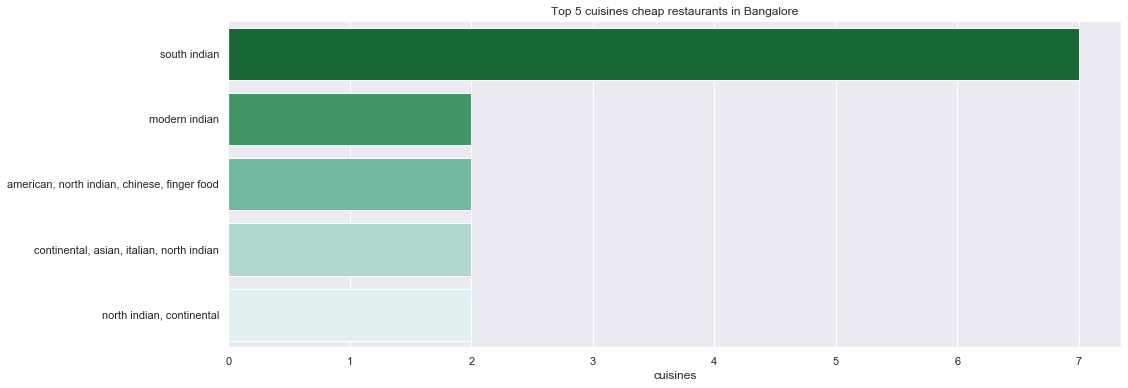

In [67]:
# Plotting the rate of the restaurants
plt.figure(figsize=(16, 6))

sns.barplot(y=top_cheap.cuisines.value_counts()[:5].index,x=top_cheap.cuisines.value_counts()[:5],
            orient='h', palette="BuGn_r").set_title('Top 5 cuisines cheap restaurants in Bangalore')

Text(0.5, 1.0, 'Location top cheap restaurants in Bangalore')

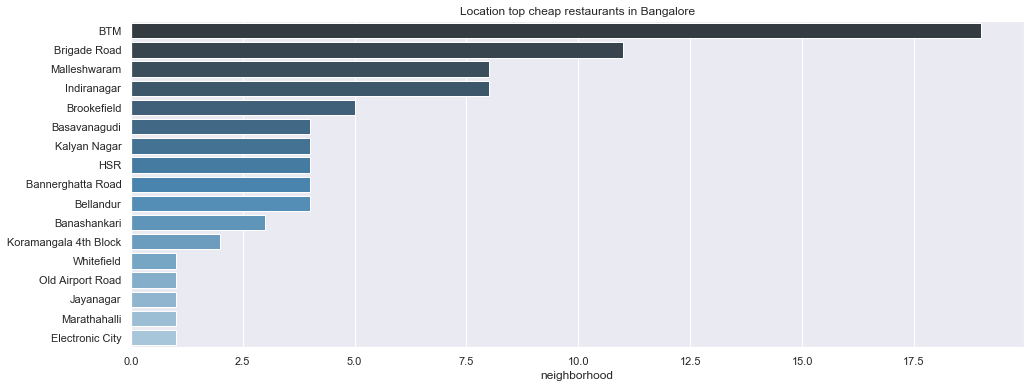

In [68]:
# Plotting the neighborhoods where the cheap restaurants are located
plt.figure(figsize=(16, 6))

sns.barplot(y=top_cheap.neighborhood.value_counts().index,x=top_cheap.neighborhood.value_counts(),
            orient='h', palette="Blues_d").set_title('Location top cheap restaurants in Bangalore')

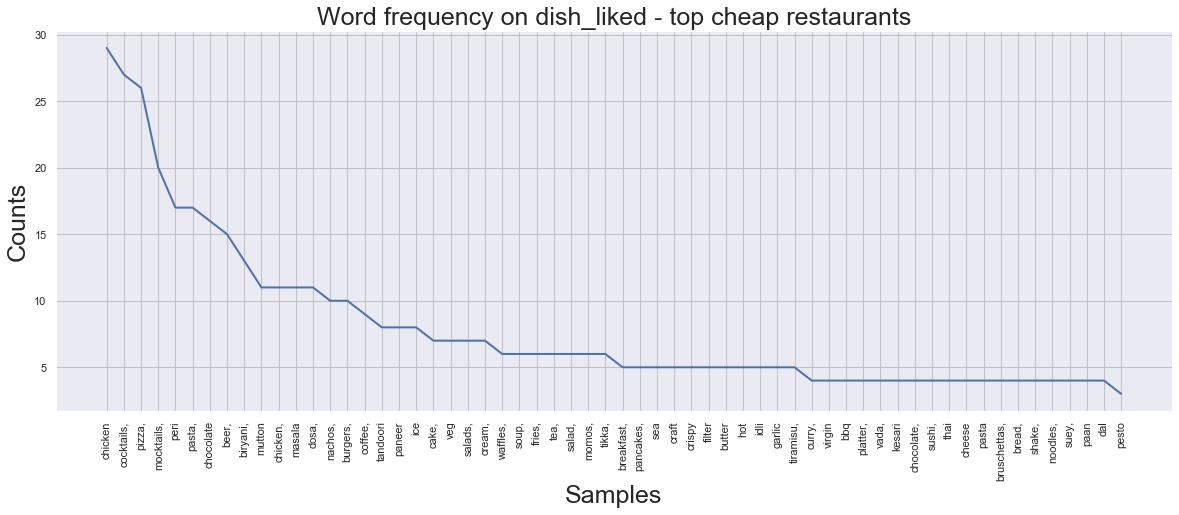

In [69]:
#Dish liked in cheap restaurants
freq_dist = FreqDist([word for text in top_cheap.dish_liked.str.replace('[^a-za-z0-9^,!.\/+-=]',' ') for word in text.split()])
plt.figure(figsize=(20, 7))
plt.title('Word frequency on dish_liked - top cheap restaurants').set_fontsize(25)
plt.xlabel('').set_fontsize(25)
plt.ylabel('').set_fontsize(25)
freq_dist.plot(60,cumulative=False)
plt.show()

In [70]:
#Top 10 Expensive restaurants - low cost, high rating & high votes
top_expensive = pd.merge(expensive, df_votes, how='inner', on=['name'])
top_expensive = top_expensive.sort_values(by=['average_cost'])
top_expensive.head(10)

,name,average_cost,neighborhood,rest_type,cuisines,online_order,book_table,dish_liked,rate,votes
0,Rim Naam - The Oberoi,3000.0,Brigade Road,fine dining,thai,No,No,"seafood soup, mocktails, mushroom salad, wine,...",4.6,979
2,Karavalli - The Gateway Hotel,3500.0,Brigade Road,fine dining,"mangalorean, konkan, seafood, kerala",No,Yes,"appam, fish, sea food, cocktails, prawn, thali...",4.5,674
1,Alba - JW Marriott Bengaluru,4000.0,Brigade Road,fine dining,italian,No,Yes,"pizza, tiramisu, pasta, risotto, lobster, pann...",4.5,583


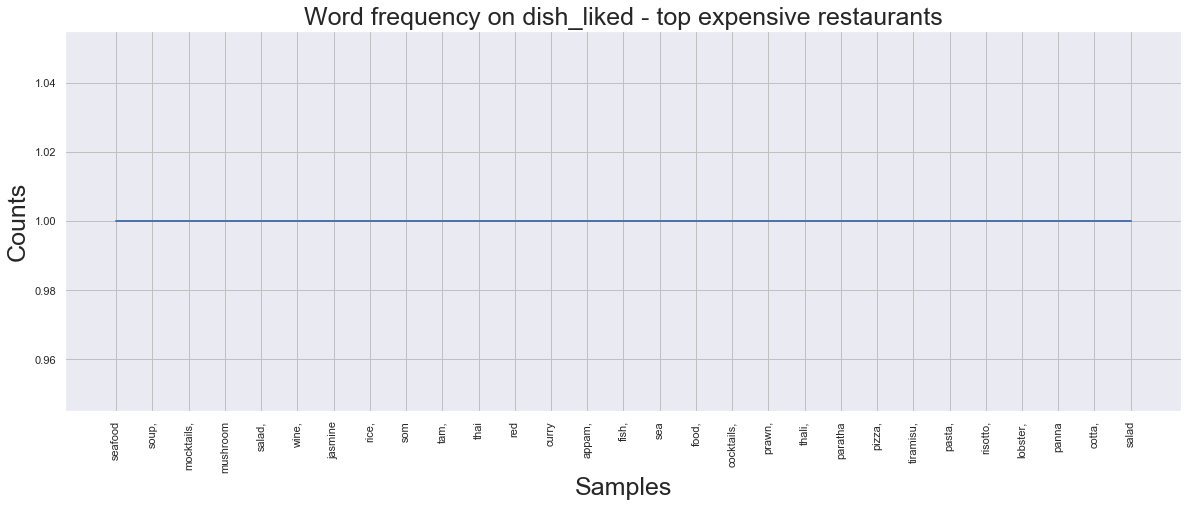

In [71]:
#Dish liked in expensive restaurants
freq_dist = FreqDist([word for text in top_expensive.dish_liked.str.replace('[^a-za-z0-9^,!.\/+-=]',' ') for word in text.split()])
plt.figure(figsize=(20, 7))
plt.title('Word frequency on dish_liked - top expensive restaurants').set_fontsize(25)
plt.xlabel('').set_fontsize(25)
plt.ylabel('').set_fontsize(25)
freq_dist.plot(60,cumulative=False)
plt.show()

## Conclusions

**General trends from the restaurants**

    1) Most of the restaurants offer online order (59%)
    2) The majority of restaurants do not offer the possibility to book a table (87.5%)
    3) Almost 50% of restaurants has rating between 3 and 4.
    4) Restaurants having rating more than 4.5 are very rare.
    5) The top 5 preferred cuisines are: North Indian, Chinese, South Indian & Biryani
    6) The average cost for 2 pax is 555. Which means that there are more cheap restaurants than expensive ones.
    7) The top 5 neighborhoods with restaurants are: BTM, Koramangala 7th, 5th, 4th & 6th Block
    8) It looks like there is a moderate correlation between average_cost and rates and votes. There is a strong correlation between average_cost and the option to book a table. We can venture that if you can book a table, the restaurant will most likely be expensive.
    
**General trends from cheap restaurants**
    
    1) Most of the restaurants do not offer online order (60.5%).
    2) The top 3 preferred cuisines are: South Indian, Modern Indian, North Indian.
    3) The top 3 locations are: BTM, Brigade road, Malleshwaram.
    4) The top 3 offered dishes are: chicken, pizza & pasta/ & The drinks: cocktails & mocktails.
    
**Trends from expensive restaurants** (the sample is pretty small to generalize)

    1) Do not offer online order.
    2) They offer the possibility of booking a table.
    3) Cuisines: thai, mangalorean & italian

**Recommendations to open a new restaurant**

There are more cheap/affordable restaurants than expensive ones, this says a lot about the preferences about habitants in Bangalore, this is why I would go for an affordable restaurant:
        a) Chains are popular, so if the first restaurant goes well then I would invest in turning it into a chain
        a) Offer online order - as it is a differential added value
        b) Cuisine: there are no good cheap Chinese or Biryani restaurants
        c) Location: there are no good cheap restaurants in Koramangala 4th Block, Jayanagar, Koramangala 7th Block, Koramangala 5th Block
        
    